## Distibuted dataset computation

Dask allow to manage large dataset through Pandas, the common python library for dataset management.
Pandas is great for tabular datasets that fit in memory. Dask becomes useful when the dataset you want to analyze is larger than your machine's RAM.

### Why Dask.dataframe?

The dask.dataframe module implements a blocked parallel DataFrame object that mimics a large subset of the Pandas DataFrame. One Dask DataFrame is comprised of many in-memory pandas DataFrames separated along the index. One operation on a Dask DataFrame triggers many pandas operations on the constituent pandas DataFrames in a way that is mindful of potential parallelism and memory constraints.

On the other hand, Dask.dataframe it's really important for two reasons mainly:


+ Dask.dataframe should be familiar to Pandas users
+ The partitioning of dataframes is important for efficient queries

### What is “partitioning” ?

Repartition is a technique to reduce overhead and necessary to exploit the power of a cluster.
Assume that you have a 2Tb dataset, in this case you may have two main problems:
+ Probably this dataset wont fit you RAM (too much larger)
+ The  time necessary to send 2Tb of data to each worker of the cluster is too much long, even with powerful networks

Your Dask DataFrame is split up into many Pandas DataFrames. We sometimes call these “partitions”, and often the number of partitions is decided for you. For example, it might be the number of CSV files from which you are reading. However, over time, as you reduce or increase the size of your pandas DataFrames by filtering or joining, it may be wise to reconsider how many partitions you need. There is a cost to having too many or having too few.


Partitions should fit comfortably in memory (smaller than a gigabyte) but also not be too many. Every operation on every partition takes the central scheduler a few hundred microseconds to process. 
This means that the number of partition shouldbe reasonable, smaller partitions should increase the overhead on execution context of a worker, smaller partitions may not fit the worker's RAM.

In some situations is that you load lots of data into reasonably sized partitions (Dask’s defaults make decent choices). Anyway, if you filter down your dataset to only a small fraction of the original. At this point, it is wise to regroup your many small partitions into a few larger ones. 

### Example of Dask.dataframe

In [1]:
import os
import dask
from distributed import Client
import pandas as pd
from glob import iglob
import dask.dataframe as dd

c = Client('dask-scheduler:8786')

# start to read a series of CSV

#path = os.path.join('data', 'accounts.*.csv')

#all_rec = iglob(path, recursive=True)     
#dataframes = (pd.read_csv(f) for f in all_rec)
#big_dataframe = pd.concat(dataframes, ignore_index=True)

## if in all your workers the data are in the same position you can read the data directly with pandas
filename = os.path.join('data', 'accounts.*.csv')
df = dd.read_csv(filename)

# read them into  a distributed dataset
#df = dd.from_pandas(big_dataframe, npartitions=20)

# load and count number of rows
df.head()

,id,names,amount
0,9,Wendy,15
1,15,Victor,77
2,381,Bob,3064
3,358,Ingrid,2041
4,299,Kevin,204


In [2]:
%time len(df)

CPU times: user 21.9 ms, sys: 0 ns, total: 21.9 ms
Wall time: 1.13 s


3000000

In [3]:
c.close()

What would have happened in this example if you had read the file from Dask directly?

+ Dask investigated the input path and found that there are three matching files
+ a set of jobs was intelligently created for each chunk - one per original CSV file in this case
+ each file was loaded into a pandas dataframe, had len() applied to it
+ the subtotals were combined to give you the final grant total.

### Real Data
Lets try this with an extract of flights in the USA across several years. This data is specific to flights out of the three airports in the New York City area.

In [7]:
from glob import iglob
import pandas as pd

c = Client('dask-scheduler:8786')

#path = os.path.join('data', 'nycflights', '*.csv')

#all_rec = iglob(path, recursive=True)     
#dataframes = (pd.read_csv(f, parse_dates={'Date': [0, 1, 2]}) for f in all_rec)
#big_dataframe = pd.concat(dataframes, ignore_index=True)

# read directly with pandas --> the file must be present in all you workers
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]})

#df = dd.from_pandas(big_dataframe, npartitions=2)
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=4,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [8]:
# let's see how it's structured the dataset (partitions, type of each column...) 

#try to repartite the df and see how change
df = df.repartition(npartitions=8)
df


,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=8,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


It's interesting to observe that the respresentation of the dataset contains no data. Frthermore, Dask has just done enough to read the start of the first file, and infer the column names and types.

In [9]:
# take a look to the first elments
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1993-01-29,5,1055.0,1055,1228.0,1212,US,66,NaN,93.0,...,NaN,16.0,0.0,EWR,BUF,282.0,NaN,NaN,0,0
1,1993-01-30,6,1052.0,1055,1214.0,1212,US,66,NaN,82.0,...,NaN,2.0,-3.0,EWR,BUF,282.0,NaN,NaN,0,0
2,1993-01-31,7,1103.0,1055,1213.0,1212,US,66,NaN,70.0,...,NaN,1.0,8.0,EWR,BUF,282.0,NaN,NaN,0,0
3,1993-01-03,7,1736.0,1729,1838.0,1831,US,70,NaN,62.0,...,NaN,7.0,7.0,LGA,SYR,198.0,NaN,NaN,0,0
4,1993-01-04,1,1730.0,1729,1825.0,1831,US,70,NaN,55.0,...,NaN,-6.0,1.0,LGA,SYR,198.0,NaN,NaN,0,0


In [10]:
# this take some samples from the end of the dataset, try to run and see how happen
df.tail()

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+----------------+---------+----------+
| Column         | Found   | Expected |
+----------------+---------+----------+
| CRSElapsedTime | float64 | int64    |
| TailNum        | object  | float64  |
+----------------+---------+----------+

The following columns also raised exceptions on conversion:

- TailNum
  ValueError("could not convert string to float: 'N54711'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'CRSElapsedTime': 'float64',
       'TailNum': 'object'}

to the call to `read_csv`/`read_table`.

In [16]:
c.close()

### What just happened?
Unlike pandas.read_csv which reads in the entire file before inferring datatypes, dask.dataframe.read_csv only reads in a sample from the beginning of the file (or first file if using a glob). These inferred datatypes are then enforced when reading all partitions.

In this case, the datatypes inferred in the sample are incorrect. The first n rows have no value for CRSElapsedTime (which pandas infers as a float), and later on turn out to be strings (object dtype). Note that Dask gives an informative error message about the mismatch. When this happens you have a few options:

+ Specify dtypes directly using the dtype keyword. This is the recommended solution, as it's the least error prone (better to be explicit than implicit) and also the most performant.
+ Increase the size of the sample keyword (in bytes)
+ Use assume_missing to make dask assume that columns inferred to be int (which don't allow missing values) are actually floats (which do allow missing values). In our particular case this doesn't apply.

In our case we'll use the first option and directly specify the dtypes of the offending columns.
When you have dataset contains "disturbed data" you should always specify the type of the columns, specially if only a few columns contains data with noise. This solution is the better one for three main reasons:
+ Dask don't have to infer the type of data with an improvement of the perfomances
+ You can use the information that you have about the dataset, hence you can improve some operations
+ The cluster don't have to comunicate with each worker for dataset analysis with an overhead reduction

Increase the size of the sampled elements it's not always a good solution. Let's suppose that you have a 5 billion record dataset, ~5Tb of data. Now let's suppose that the first billion of records cotains noise and disturbed data. In this case you should load more than 1 billion records in order to infer the right type of the columns with a huge amount of time and a huge computationa and networks overhead.

The ```assume_missing``` approach can be used in some data, when you don't know the nature of the data how data are made. Anyway, the first solution is still the best.

In [11]:
c = Client('dask-scheduler:8786')
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]})

df.tail()

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+----------------+---------+----------+
| Column         | Found   | Expected |
+----------------+---------+----------+
| CRSElapsedTime | float64 | int64    |
| TailNum        | object  | float64  |
+----------------+---------+----------+

The following columns also raised exceptions on conversion:

- TailNum
  ValueError("could not convert string to float: 'N54711'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'CRSElapsedTime': 'float64',
       'TailNum': 'object'}

to the call to `read_csv`/`read_table`.

In [17]:

df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

#now it works!
df.tail()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


### Computations with dask.dataframe
We compute the maximum of the DepDelay column. With just pandas, we would loop over each file to find the individual maximums, then find the final maximum over all the individual maximums

In [19]:
c = Client('dask-scheduler:8786')

In [21]:
import pandas as pd
import time
filenames = [
    os.path.join('data', 'nycflights', '1993.csv'),
    os.path.join('data', 'nycflights', '1994.csv'),
    os.path.join('data', 'nycflights', '1998.csv'),
    os.path.join('data', 'nycflights', '1999.csv')
]

start_time = time.time()
print(filenames)
maxes = []
for fn in filenames:
    pdf = pd.read_csv(fn)
    time.sleep(0.5) ##dummy for represent complex computation
    maxes.append(pdf.DepDelay.max())
    
final_max = 0
for m in maxes:
    if m >= final_max:
        final_max = m
end_time = time.time()
print("Times in seconds: "+str(end_time-start_time))
print(final_max)

['data/nycflights/1993.csv', 'data/nycflights/1994.csv', 'data/nycflights/1998.csv', 'data/nycflights/1999.csv']
Times in seconds: 4.863727569580078
1435.0


In [22]:
start_time = time.time()
final_max = df.DepDelay.max().compute()
end_time = time.time()
print("Times in seconds: "+str(end_time-start_time))
print(final_max)

Times in seconds: 2.165123701095581
1435.0


#### Hint:

As with dask.delayed, we need to call .compute() when we're done. Up until this point everything is lazy.
Dask will delete intermediate results (like the full pandas dataframe for each file) as soon as possible.
This lets us handle datasets that are larger than memory
This means that repeated computations will have to load all of the data in each time.

As with Delayed objects, you can view the underlying task graph using the ```.visualize``` method:

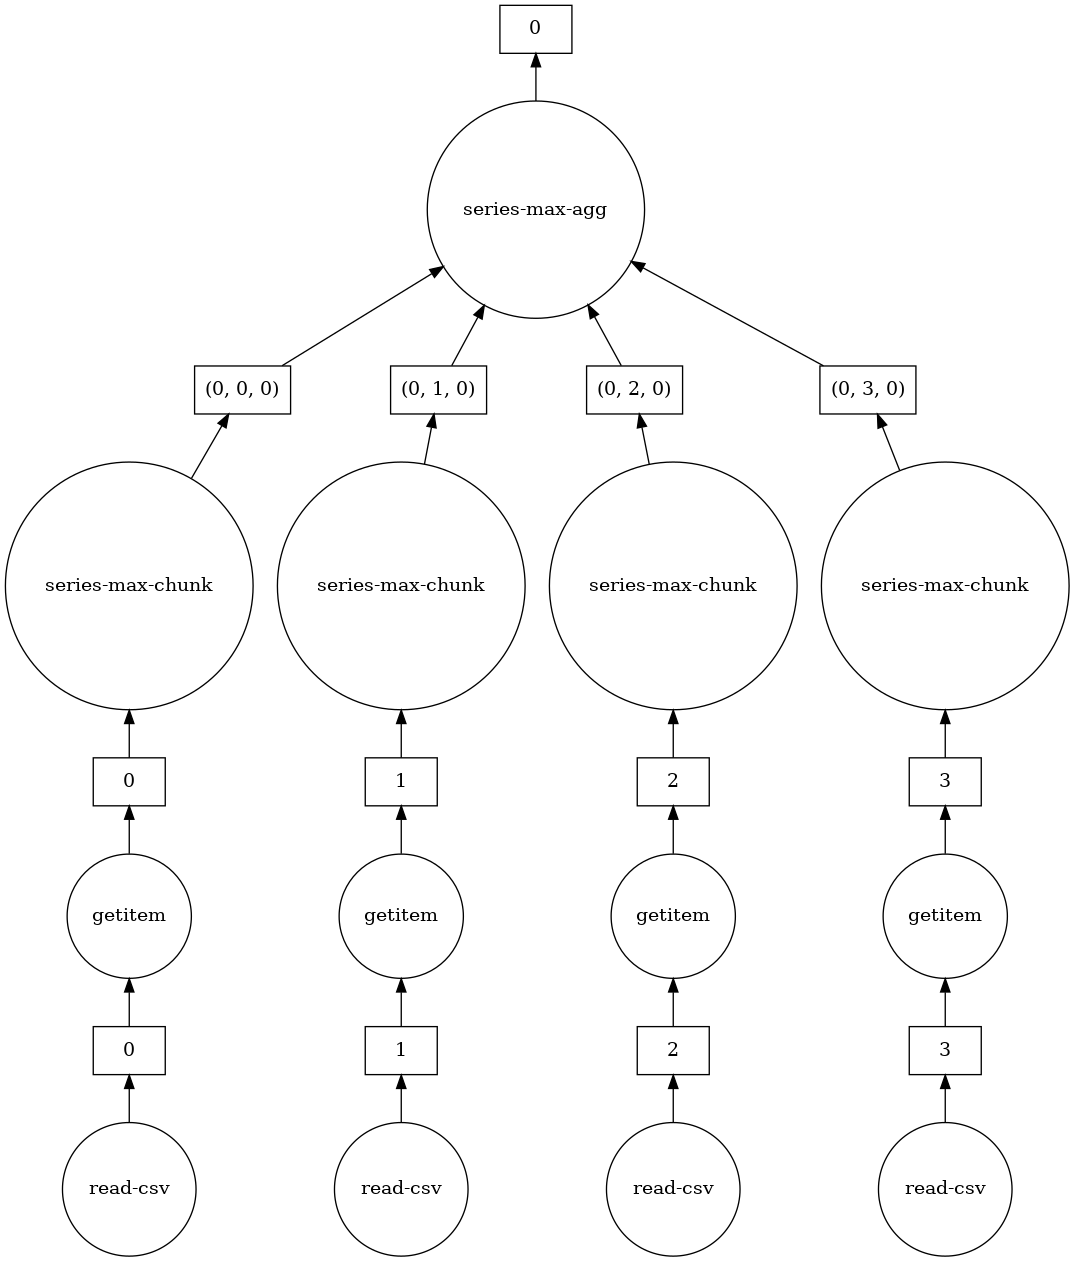

In [23]:
df.DepDelay.max().visualize()

### Exercise 1

How many rows are in our dataset?

In [27]:
df.count().compute()

Date                 1047059
DayOfWeek            1047059
DepTime              1011774
CRSDepTime           1047059
ArrTime              1008999
CRSArrTime           1047059
UniqueCarrier        1047059
FlightNum            1047059
TailNum               526432
ActualElapsedTime    1008999
CRSElapsedTime       1046208
AirTime               504230
ArrDelay             1008999
DepDelay             1011774
Origin               1047059
Dest                 1047059
Distance             1046935
TaxiIn                526432
TaxiOut               526432
Cancelled            1047059
Diverted             1047059
dtype: int64

### Exercise 2
In total, how many non-canceled flights were taken? Print the result and see the computation graph

Non cancelled flights: 1011774


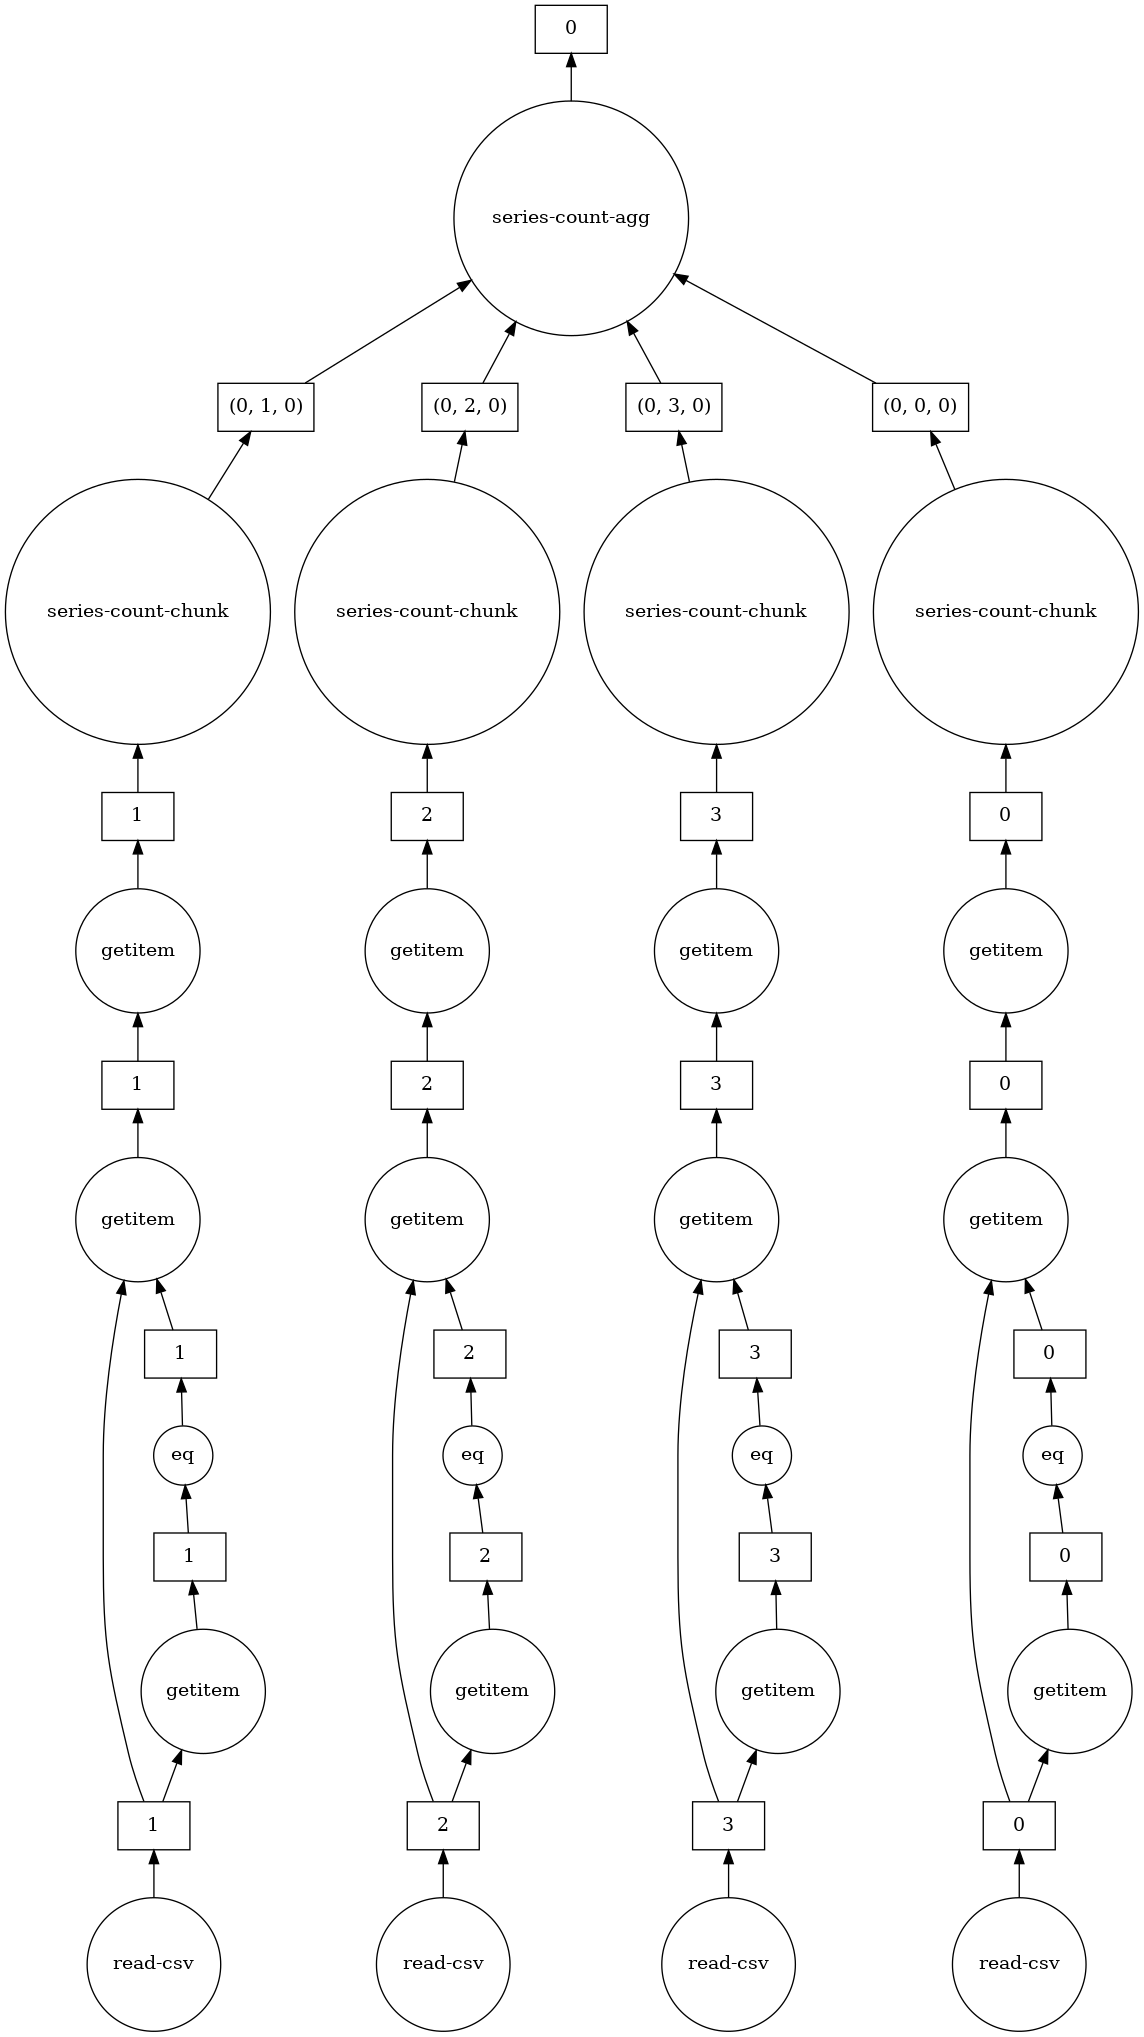

In [28]:
non_cancelled = df[df.Cancelled == False].Cancelled.count().compute()

print("Non cancelled flights: "+str(non_cancelled))

df[df.Cancelled == False].Cancelled.count().visualize()

### Exercise 3
In total, how many non-cancelled flights were taken from each airport? Try to get the result, print it and see the computation graph

#### Hints: 
use the ```groupby``` function

Cancelled per airport: Origin
EWR    458876
JFK    169232
LGA    383666
Name: Origin, dtype: int64


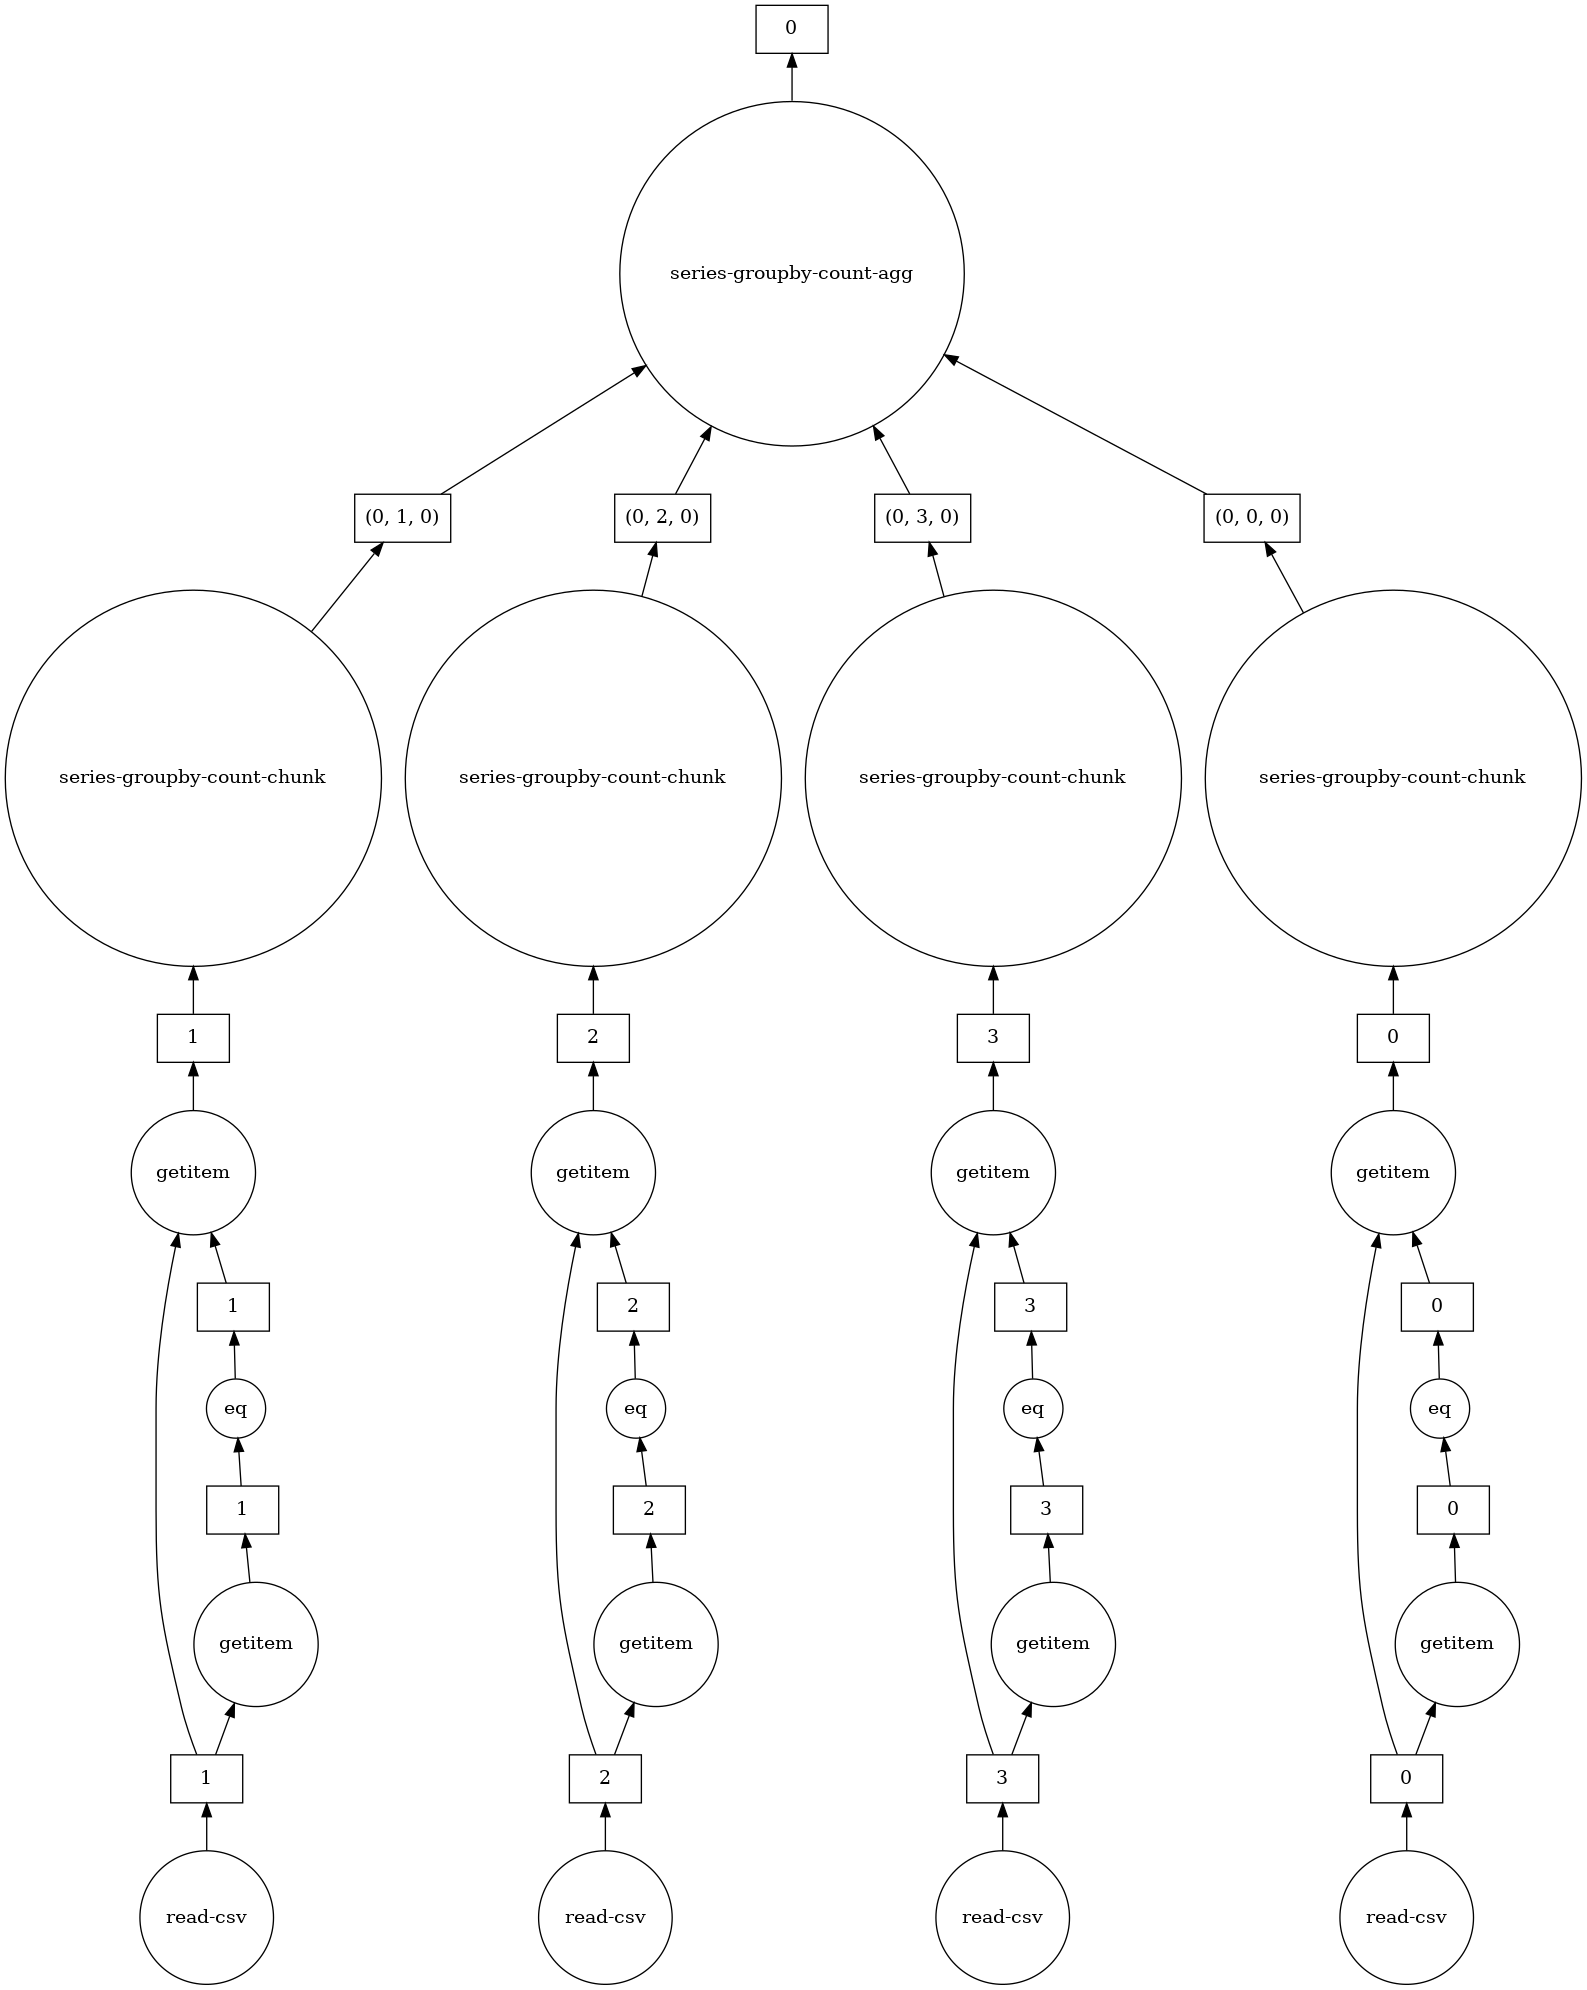

In [29]:
print("Cancelled per airport: "+str(df[df.Cancelled == False].groupby('Origin').Origin.count().compute()))
df[df.Cancelled == False].groupby('Origin').Origin.count().visualize()

### Exercise 4
What was the average departure delay from each airport? Try to get the result, print it and see the computation graph

#### Hints:
is this approach faster or slower that what we have done before?

Departure mean delay for each airport: Origin
EWR    11.266091
JFK     9.164537
LGA     7.967055
Name: DepDelay, dtype: float64


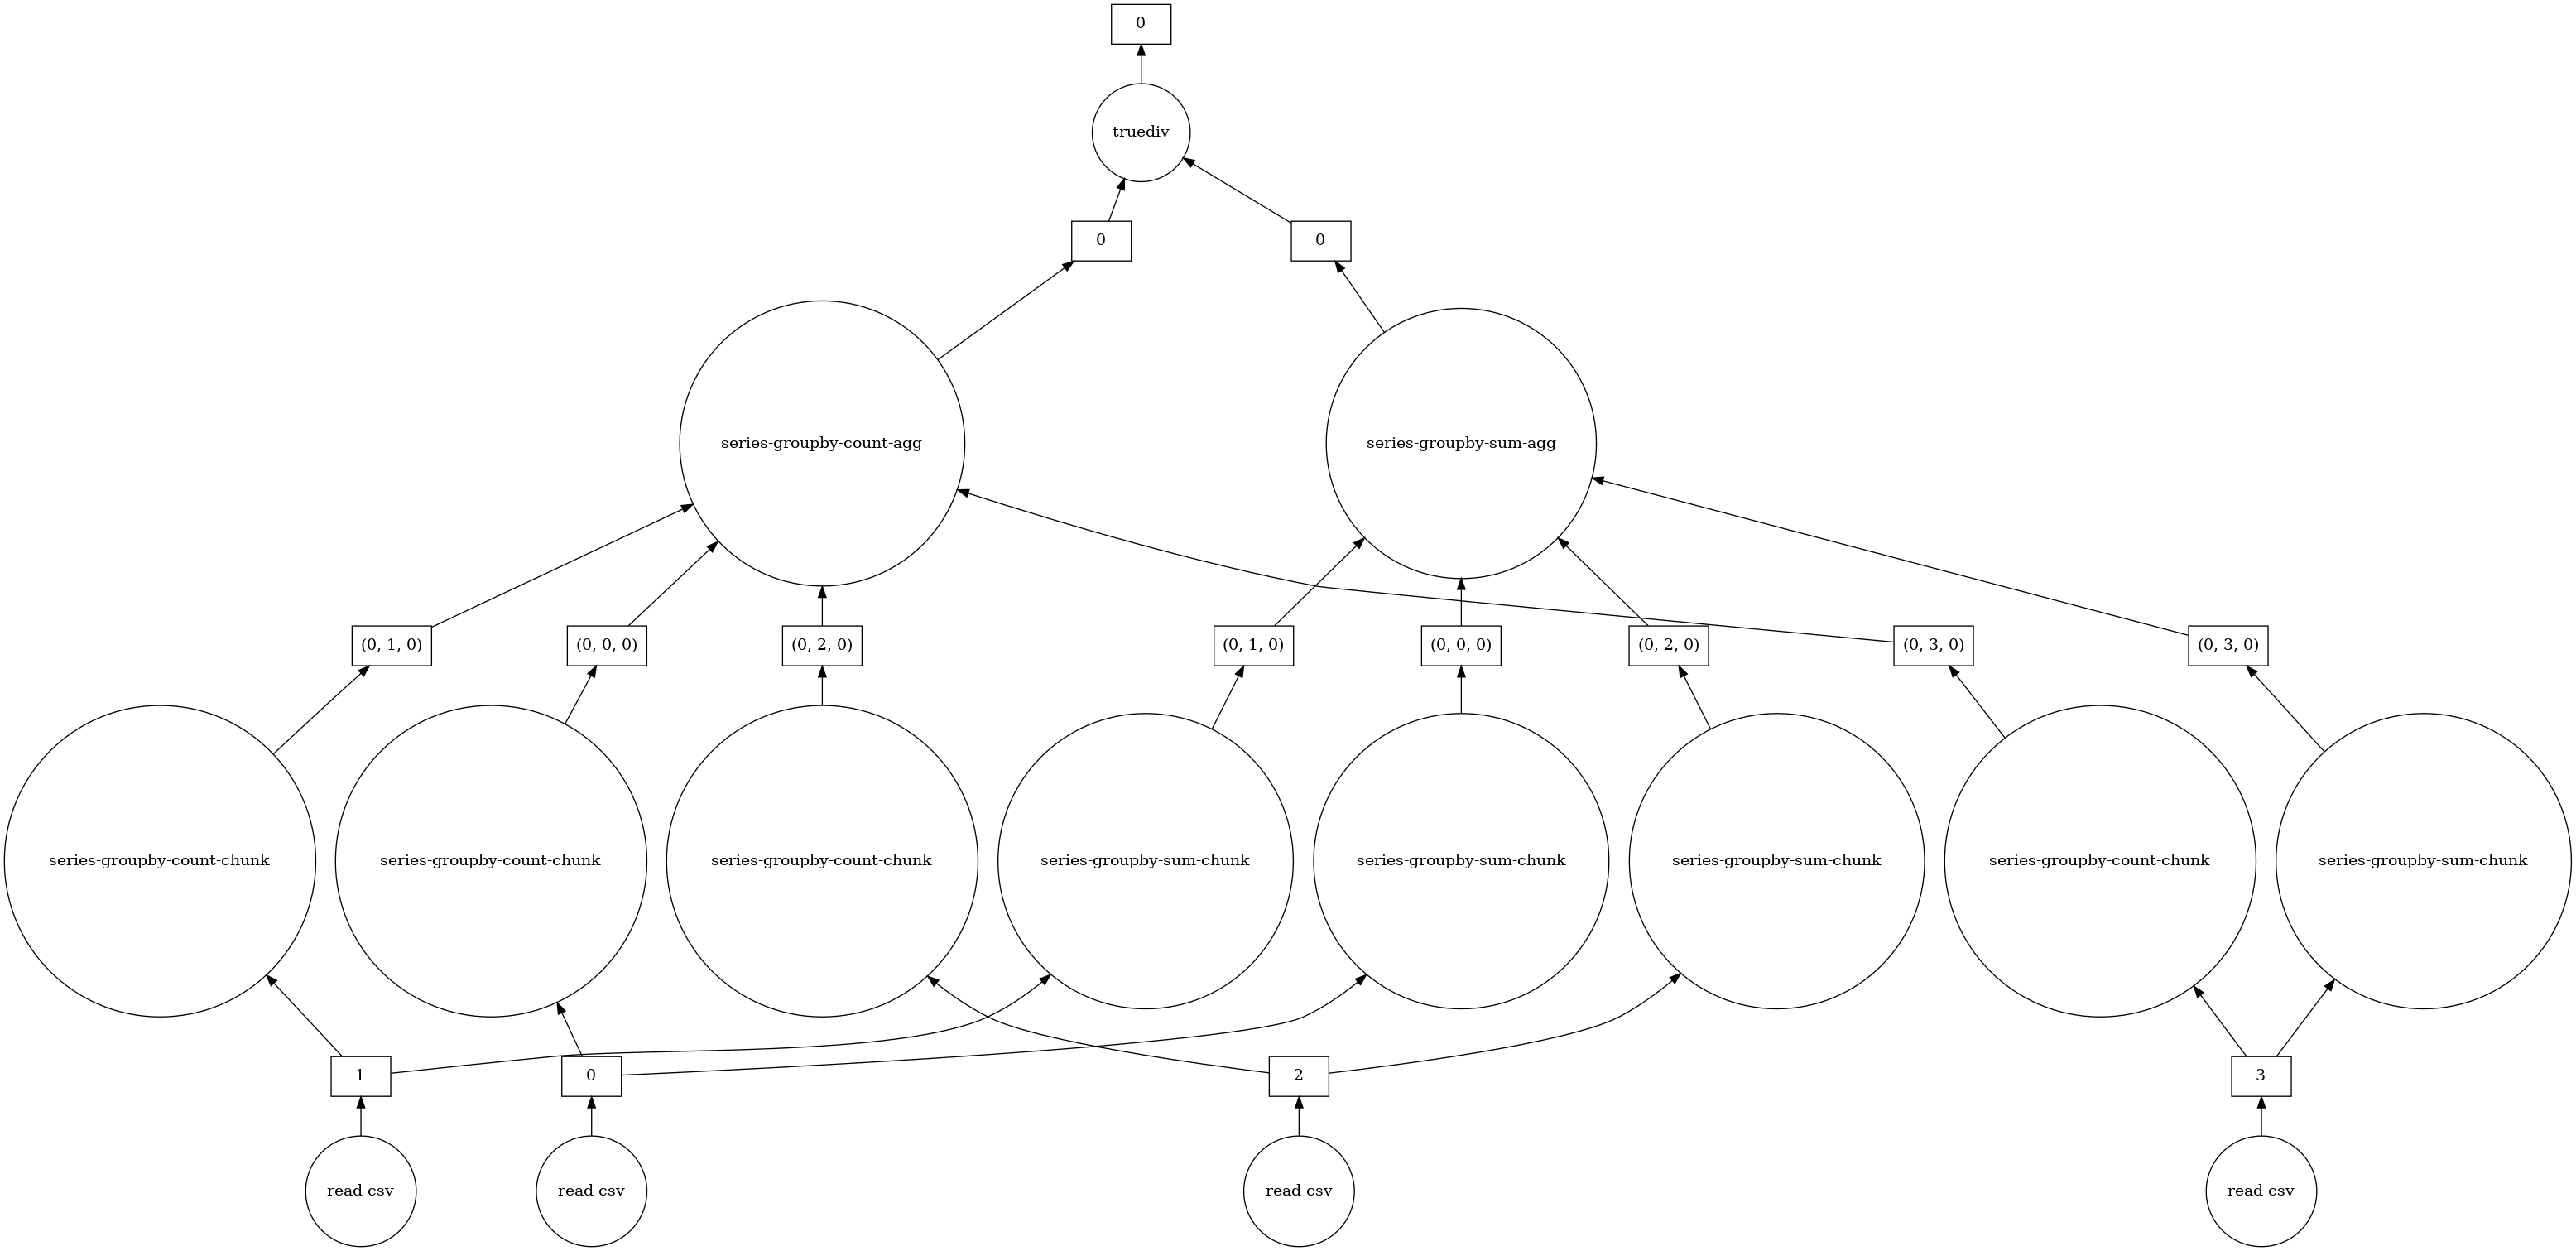

In [30]:
print("Departure mean delay for each airport: "+str(df.groupby("Origin").DepDelay.mean().compute()))
df.groupby("Origin").DepDelay.mean().visualize()

### Exercise 5
What day of the week has the worst average departure delay? Try to get the result, print it and see the computation graph

Departure mean delay for each airport: DayOfWeek
1     9.299939
2     7.797254
3    10.141425
4    10.925460
5    11.625745
6     7.858641
7     9.693491
Name: DepDelay, dtype: float64


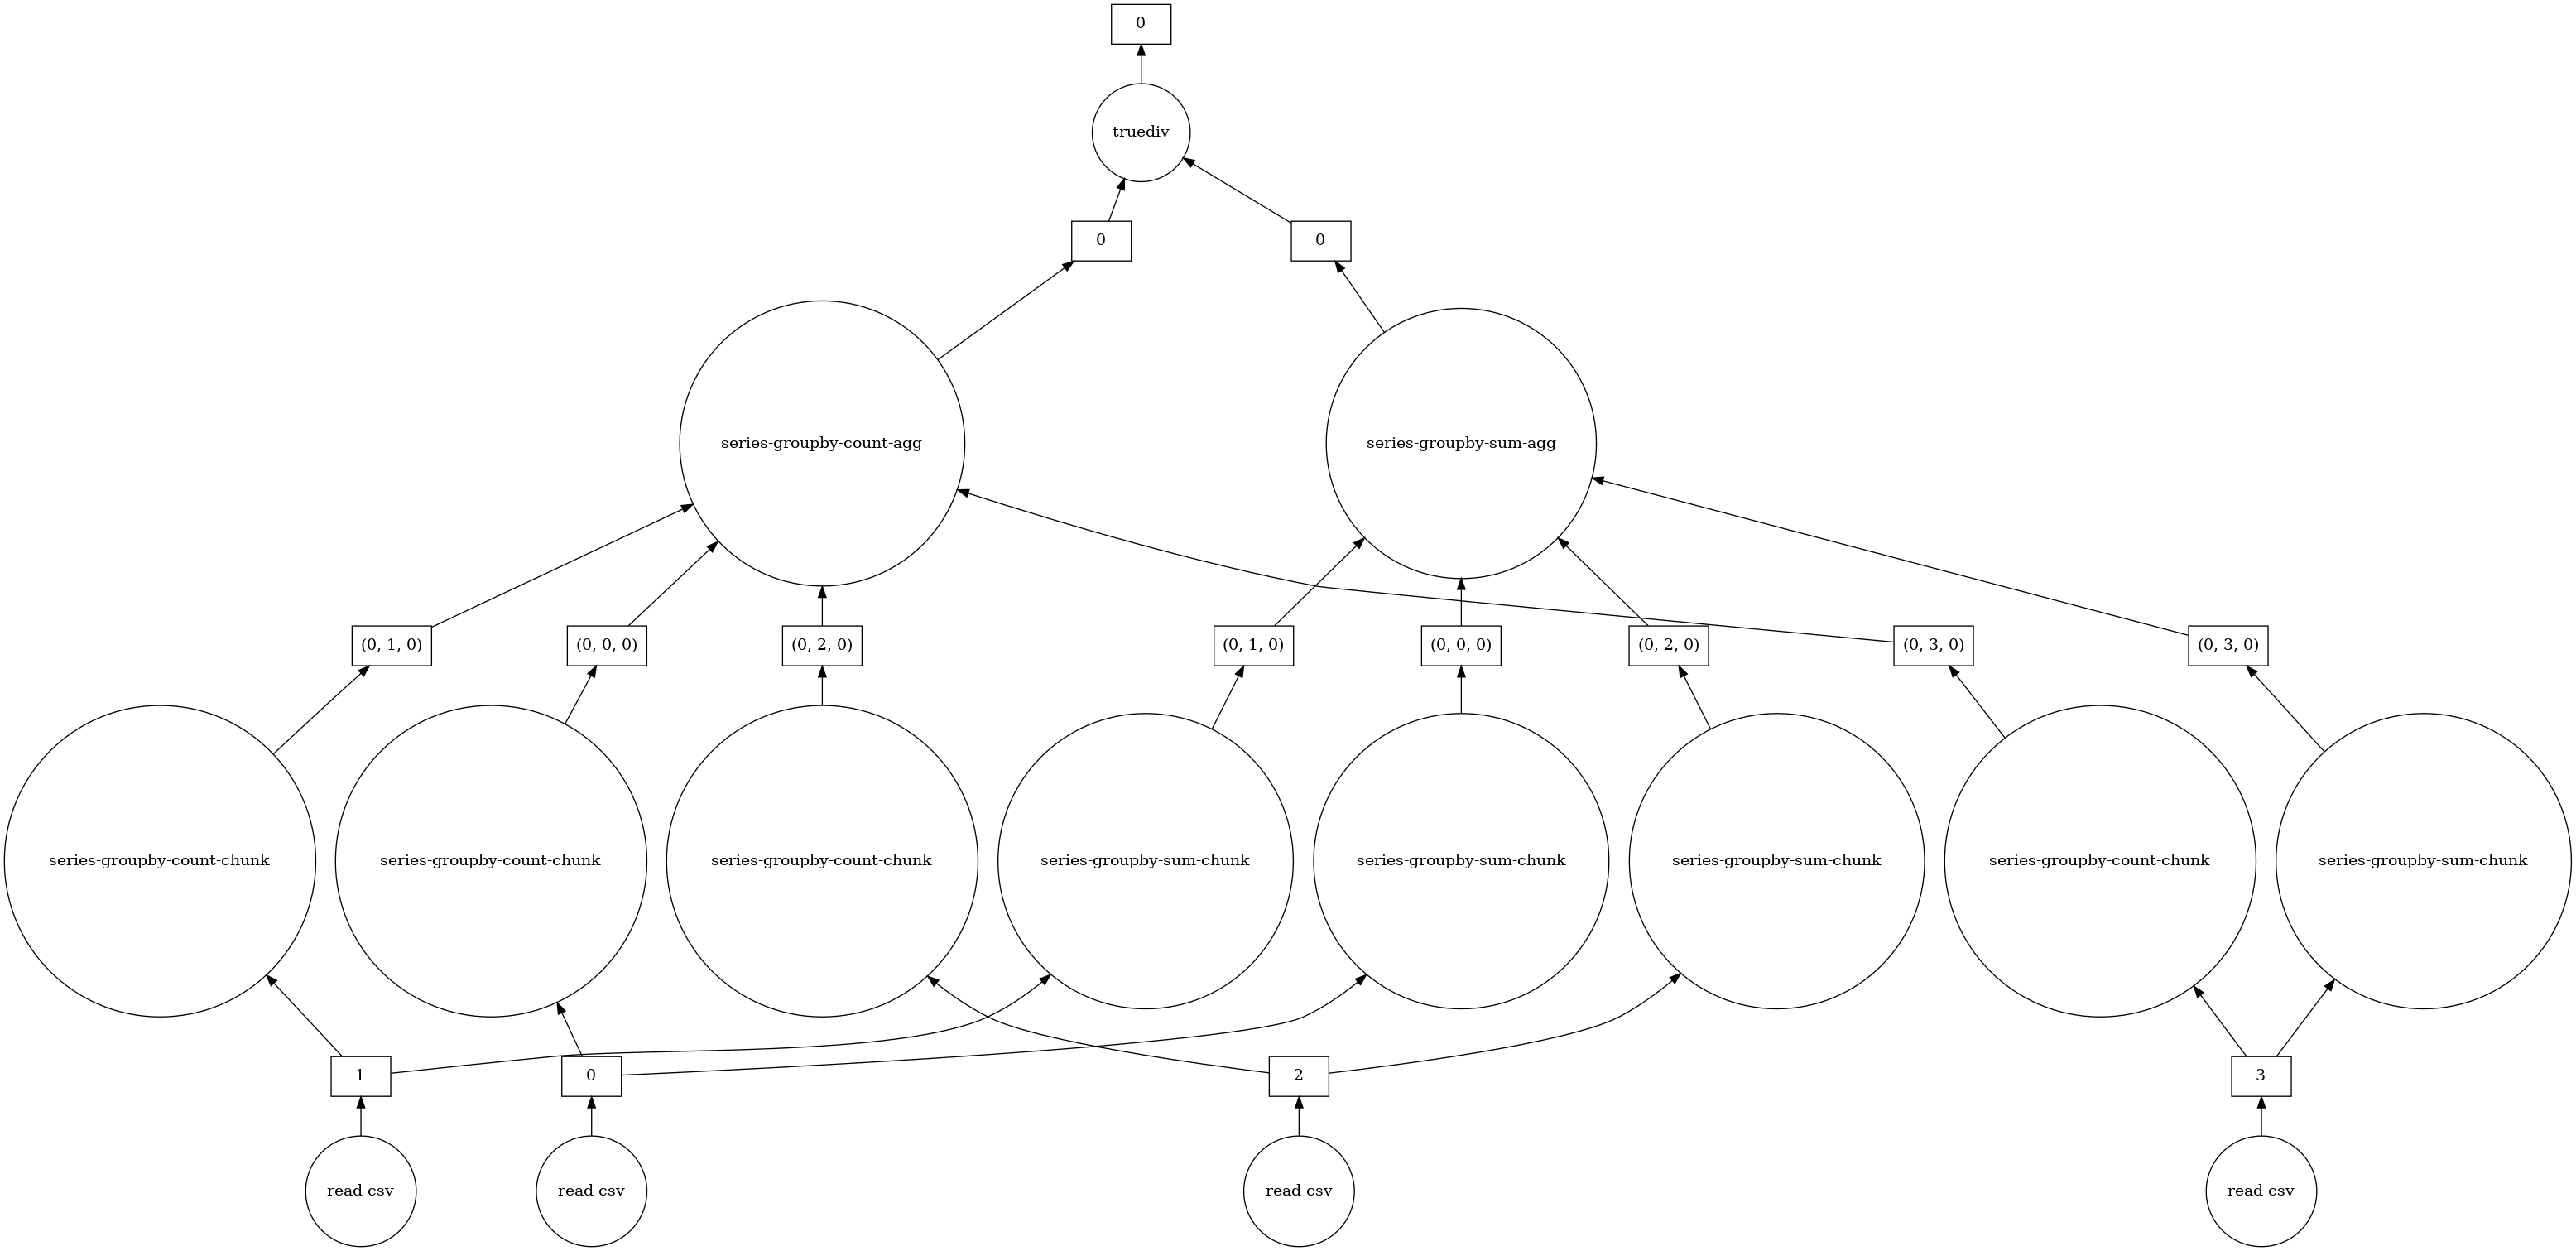

In [33]:
print("Departure mean delay for each airport: "+str(df.groupby("DayOfWeek").DepDelay.mean().compute()))
df.groupby("DayOfWeek").DepDelay.mean().visualize()

### Shared, reapeated and intermediate computations

When computing all of the above, we sometimes did the same operation more than once. For most operations, dask.dataframe hashes the arguments (aka "placeholder", that we have already see in the first lecture), allowing duplicate computations to be shared, and only computed once.

For example, lets compute the mean and standard deviation for departure delay of all non-canceled flights. Since dask operations are lazy, those values aren't the final results yet. They're just the recipe require to get the result.

If we want to change the approach, we can compute them with two calls to compute,. In this case there is no sharing of intermediate computations with an improvement in term of speed

In [34]:
non_cancelled = df[~df.Cancelled]
mean_delay = non_cancelled.DepDelay.mean()
std_delay = non_cancelled.DepDelay.std()

In [37]:
%%time

mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: user 70.9 ms, sys: 5.11 ms, total: 76 ms
Wall time: 4.14 s


In [36]:
%%time
mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 39.5 ms, sys: 4.36 ms, total: 43.9 ms
Wall time: 2.18 s


### What it is happened?

Using dask.compute takes ~ 1/2 the time. This is because the task graphs for both results are merged when calling dask.compute, allowing shared operations to only be done once instead of twice. In particular, using dask.compute only does the following once:

+ the calls to read_csv
+ the filter ```(df[~df.Cancelled])```
+ some of the necessary reductions (sum, count)

Let's see the computation graph:


In [39]:
dask.visualize(mean_delay, std_delay)
#c.close()

Wath we can see is that a lot of operation have been merged and used one time. This is essential in order to work with big data and clusters.
Avoid the repetition of operations may increase the performances of your cluster and speed up the whole process between the workers.

### Differences between Dask.dataframe and Pandas

Pandas is more mature and fully featured than dask.dataframe. If your data fits in memory then you should use Pandas. 
Event though dask.dataframe is really powerfull, it gives you a limited pandas experience when you operate on datasets that don't fit comfortably in memory.

Be carefull, Dask.dataframe becomes meaningful for problems significantly larger than problems like what we have seen. Distributed data are awesome, but they should be used in a correct way!